<a href="https://colab.research.google.com/github/yahelrl19/ParkingLotProject/blob/main/ParkingLotProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parking Lot Project

Link: https://paperswithcode.com/paper/revising-deep-learning-methods-in-parking-lot

GitHub: https://github.com/eighonet/parking-research

Dataset: https://www.kaggle.com/datasets/braunge/aerial-view-car-detection-for-yolov5/data


Empezaremos descargando el dataset de Kaggle

In [1]:
# Instalar las dependencias necesarias
!pip install torch torchvision opencv-python matplotlib -q
!pip install kaggle -q

# Descargar el dataset usando curl
!curl -L -o aerial-view-car-detection.zip "https://www.kaggle.com/api/v1/datasets/download/braunge/aerial-view-car-detection-for-yolov5"

# Descomprimir el archivo descargado
!unzip -q aerial-view-car-detection.zip -d ./dataset

# Verificar el contenido del dataset
!ls ./dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 67.7M  100 67.7M    0     0  64.7M      0  0:00:01  0:00:01 --:--:--  282M
 mydata  'mydata128 .yaml'   mydata.yaml


Visualización y exploración del dataset

In [2]:
# Directorios de imágenes y etiquetas
train_images_dir = './dataset/mydata/mydata/images/train'
train_labels_dir = './dataset/mydata/mydata/labels/train'

test_images_dir = './dataset/mydata/mydata/images/test'
test_labels_dir = './dataset/mydata/mydata/labels/test'

# Verificar que los directorios contienen datos
import os

print(f"Imágenes de entrenamiento: {len(os.listdir(train_images_dir))}")
print(f"Etiquetas de entrenamiento: {len(os.listdir(train_labels_dir))}")

print(f"Imágenes de prueba: {len(os.listdir(test_images_dir))}")
print(f"Etiquetas de prueba: {len(os.listdir(test_labels_dir))}")

Imágenes de entrenamiento: 280
Etiquetas de entrenamiento: 280
Imágenes de prueba: 19
Etiquetas de prueba: 19


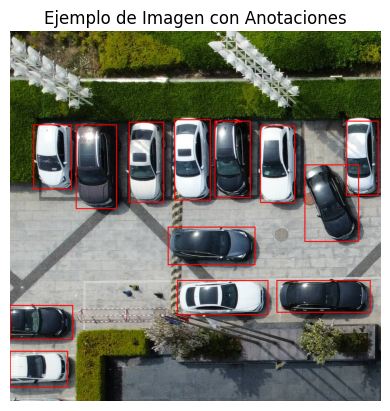

In [3]:
import cv2
import matplotlib.pyplot as plt

# Listar imágenes y etiquetas
train_image_files = sorted(os.listdir(train_images_dir))
train_label_files = sorted(os.listdir(train_labels_dir))

# Cargar una imagen de muestra
sample_image_path = os.path.join(train_images_dir, train_image_files[0])
sample_label_path = os.path.join(train_labels_dir, train_label_files[0])

# Leer la imagen
image = cv2.imread(sample_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Leer la etiqueta (formato YOLO)
with open(sample_label_path, 'r') as f:
    labels = f.readlines()

# Dibujar las cajas delimitadoras
h, w, _ = image.shape
for label in labels:
    class_id, x_center, y_center, width, height = map(float, label.strip().split())
    x1 = int((x_center - width / 2) * w)
    y1 = int((y_center - height / 2) * h)
    x2 = int((x_center + width / 2) * w)
    y2 = int((y_center + height / 2) * h)
    cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

# Mostrar la imagen con las cajas
plt.imshow(image)
plt.axis('off')
plt.title("Ejemplo de Imagen con Anotaciones")
plt.show()

# Estadísticas del dataset

Analizando imágenes del dataset...


100%|██████████| 280/280 [00:08<00:00, 32.70it/s]


Análisis completado. Resumen guardado en image_analysis_summary.csv

Resumen Estadístico:
             Width       Height  Brightness    Contrast       Noise  \
count   280.000000   280.000000  280.000000  280.000000  280.000000   
mean   1336.228571  1127.475000  120.022667   57.353054  113.055062   
std     171.704917   126.949484   11.885262    6.332851    2.366253   
min     881.000000   806.000000   75.097934   34.427901  100.945086   
25%    1211.000000  1038.000000  113.003349   54.114402  112.178117   
50%    1345.000000  1119.000000  119.799603   57.855152  113.533821   
75%    1468.000000  1221.000000  127.881262   61.404324  114.696853   
max    1733.000000  1444.000000  155.488510   71.594416  116.852749   

       Edge Density  Saturation  Intensity Variance  
count    280.000000  280.000000          280.000000  
mean       0.086178   54.547460         3329.334536  
std        0.026031   18.228960          698.795576  
min        0.021516   16.484755         1185.280392  


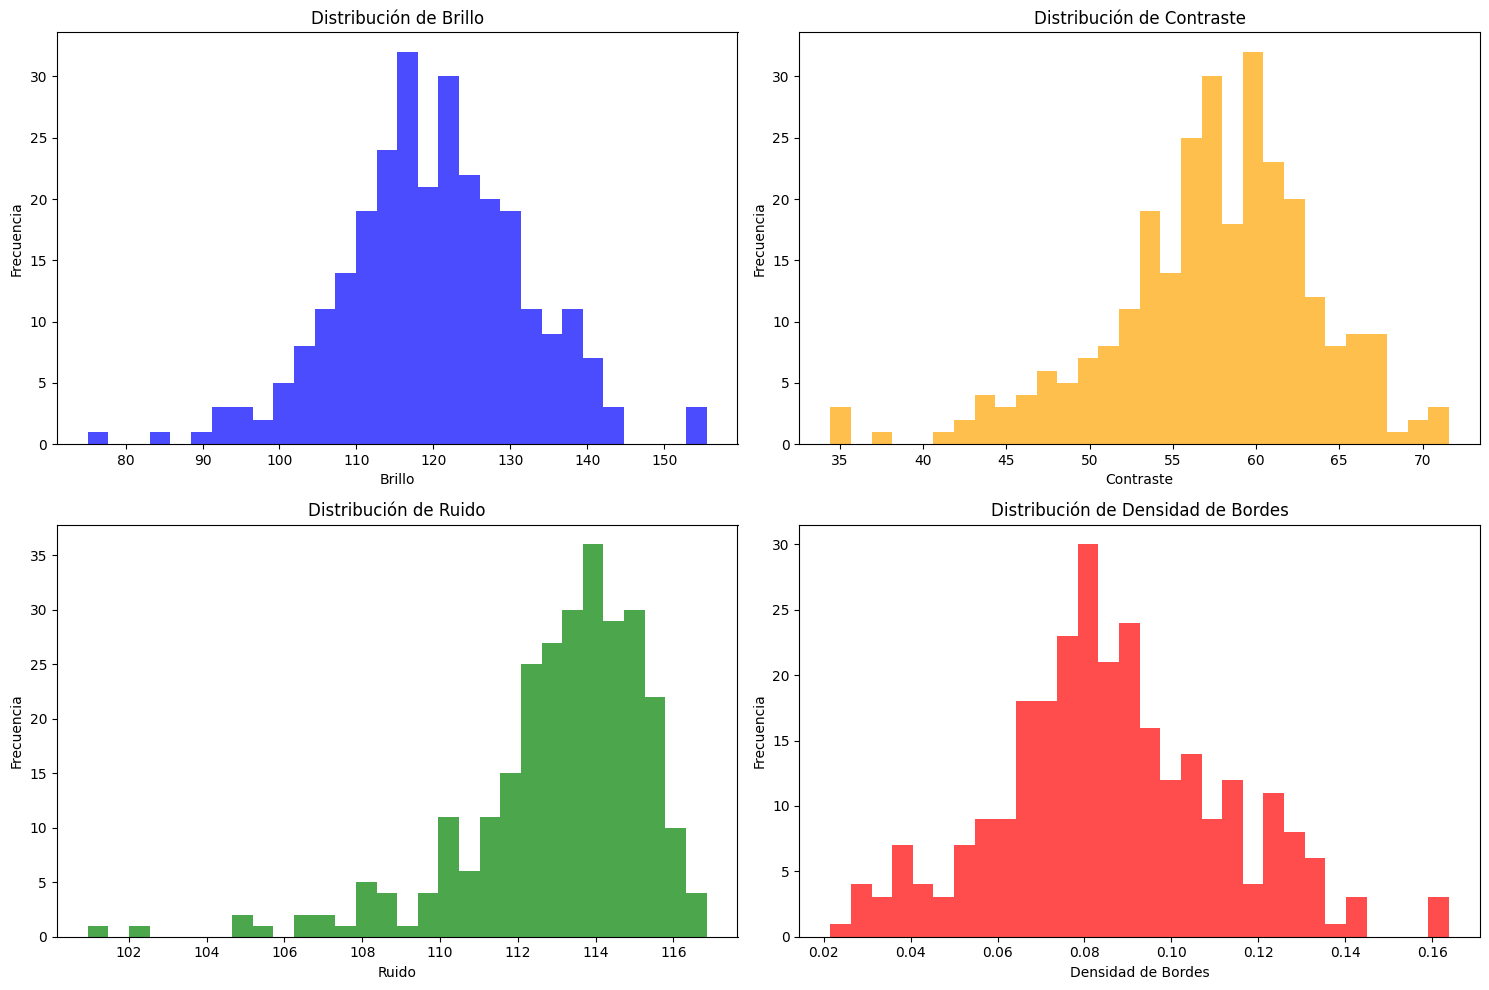

In [4]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# Ruta al directorio del dataset
images_dir = './dataset/mydata/mydata/images/train'

# Funciones de análisis
def analyze_image(image_path):
    """Analiza propiedades de una imagen y retorna un diccionario con los resultados."""
    # Cargar imagen
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Dimensiones de la imagen
    height, width = gray.shape

    # Brillo promedio
    brightness = np.mean(gray)

    # Contraste (desviación estándar de los valores de intensidad)
    contrast = np.std(gray)

    # Ruido estimado (diferencia promedio entre la imagen y un filtro de suavizado)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    noise = np.mean(np.abs(gray - blurred))

    # Bordes detectados (Canny)
    edges = cv2.Canny(gray, 100, 200)
    edge_density = np.sum(edges > 0) / (height * width)

    # Saturación promedio (canal S en espacio HSV)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    saturation = np.mean(hsv_image[:, :, 1])

    # Varianza de intensidad (medida de textura)
    intensity_variance = np.var(gray)

    return {
        "Width": width,
        "Height": height,
        "Brightness": brightness,
        "Contrast": contrast,
        "Noise": noise,
        "Edge Density": edge_density,
        "Saturation": saturation,
        "Intensity Variance": intensity_variance
    }

# Analizar todas las imágenes
results = []
image_files = sorted(os.listdir(images_dir))

print("Analizando imágenes del dataset...")
for image_file in tqdm(image_files):
    image_path = os.path.join(images_dir, image_file)
    analysis = analyze_image(image_path)
    analysis["Image"] = image_file
    results.append(analysis)

# Convertir los resultados en un DataFrame
df = pd.DataFrame(results)

# Guardar el análisis como un archivo CSV
output_file = "image_analysis_summary.csv"
df.to_csv(output_file, index=False)

print(f"Análisis completado. Resumen guardado en {output_file}")

# Mostrar resumen estadístico
print("\nResumen Estadístico:")
print(df.describe())

# Visualizar histogramas de métricas clave
plt.figure(figsize=(15, 10))

# Histograma de Brillo
plt.subplot(2, 2, 1)
plt.hist(df["Brightness"], bins=30, alpha=0.7, color="blue")
plt.title("Distribución de Brillo")
plt.xlabel("Brillo")
plt.ylabel("Frecuencia")

# Histograma de Contraste
plt.subplot(2, 2, 2)
plt.hist(df["Contrast"], bins=30, alpha=0.7, color="orange")
plt.title("Distribución de Contraste")
plt.xlabel("Contraste")
plt.ylabel("Frecuencia")

# Histograma de Ruido
plt.subplot(2, 2, 3)
plt.hist(df["Noise"], bins=30, alpha=0.7, color="green")
plt.title("Distribución de Ruido")
plt.xlabel("Ruido")
plt.ylabel("Frecuencia")

# Histograma de Densidad de Bordes
plt.subplot(2, 2, 4)
plt.hist(df["Edge Density"], bins=30, alpha=0.7, color="red")
plt.title("Distribución de Densidad de Bordes")
plt.xlabel("Densidad de Bordes")
plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()

Entrenando el modelo por medio de YOLOv5



In [5]:
# Descargando YOLOv5
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 17067, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 17067 (delta 24), reused 27 (delta 12), pack-reused 17022 (from 1)
Receiving objects: 100% (17067/17067), 15.69 MiB | 30.20 MiB/s, done.
Resolving deltas: 100% (11718/11718), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.5/898.5 kB 17.0 MB/s eta 0:00:00


In [9]:
# Configurando el mydata128 .yaml correctamente
# Crear y configurar automáticamente el archivo YAML
yaml_content = """
train: /content/dataset/mydata/mydata/images/train
val: /content/dataset/mydata/mydata/images/test

nc: 1
names: ['car']
"""

# Guardar el archivo YAML
yaml_path = "/content/dataset/mydata128.yaml"
with open(yaml_path, "w") as yaml_file:
    yaml_file.write(yaml_content)

print(f"Archivo YAML creado correctamente en {yaml_path}")

Archivo YAML creado correctamente en /content/dataset/mydata128.yaml


In [10]:
!python train.py --img 640 --batch 16 --epochs 50 --data "/content/dataset/mydata128.yaml" --weights yolov5s.pt

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-12-04 02:36:21.861136: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-04 02:36:21.883155: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-04 02:36:21.889543: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: yahelrl19 (yahelrl19-universidad-aut-noma-de-guadalajara). Use

In [11]:
!python val.py --weights runs/train/exp/weights/best.pt --data /content/dataset/mydata128.yaml --img 640

val: data=/content/dataset/mydata128.yaml, weights=['runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-388-g882c35fc Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Traceback (most recent call last):
  File "/content/yolov5/val.py", line 604, in <module>
    main(opt)
  File "/content/yolov5/val.py", line 575, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py", line 116, in decorate_context
    return func(*args, **kwargs)
  File "/content/yolov5/val.py", line 270, in run
    model = DetectMultiBackend(weights, device=device, dnn=dnn, data=data, fp16=half)
  File "/content/yolov5/models/common.py", line 489, in __init__
    mode

In [12]:
!python detect.py --weights runs/train/exp/weights/best.pt --img 640 --conf 0.5 --source /content/dataset/mydata/mydata/images/test

detect: weights=['runs/train/exp/weights/best.pt'], source=/content/dataset/mydata/mydata/images/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-388-g882c35fc Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Traceback (most recent call last):
  File "/content/yolov5/detect.py", line 437, in <module>
    main(opt)
  File "/content/yolov5/detect.py", line 432, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py", line 116, in decorate_context
    return func(*args, **kwargs)
  File "/content/yolov5/detect.py", line 166, i

# Modificación del dataset

1. Copiar las imagenes del dataset original modificadas a dataset_modified

In [13]:
import cv2
import os
import numpy as np
from tqdm import tqdm

# Directorios de entrada y salida
input_dirs = {
    "train": "/content/dataset/mydata/mydata/images/train",
    "test": "/content/dataset/mydata/mydata/images/test"
}
output_dirs = {
    "train": "/content/dataset_modified/mydata/mydata/images/train",
    "test": "/content/dataset_modified/mydata/mydata/images/test"
}

# Crear directorios de salida
for key in output_dirs:
    os.makedirs(output_dirs[key], exist_ok=True)

# Funciones de modificación
def add_gaussian_noise(image, mean=0, stddev=25):
    """Añadir ruido gaussiano a una imagen."""
    noise = np.random.normal(mean, stddev, image.shape).astype('uint8')
    noisy_image = cv2.add(image, noise)
    return noisy_image

def adjust_brightness_contrast(image, alpha=1.5, beta=50):
    """Modificar el brillo y contraste de una imagen."""
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

def apply_blur(image, ksize=(5, 5)):
    """Aplicar desenfoque gaussiano."""
    return cv2.GaussianBlur(image, ksize, 0)

def modify_image(image):
    """Aplicar una combinación de modificaciones a una imagen."""
    image = add_gaussian_noise(image)
    image = adjust_brightness_contrast(image, alpha=1.2, beta=30)
    image = apply_blur(image)
    return image

# Procesar imágenes
print("Modificando imágenes...")
for subset in input_dirs:
    input_dir = input_dirs[subset]
    output_dir = output_dirs[subset]

    # Procesar imágenes
    for file_name in tqdm(os.listdir(input_dir)):
        input_path = os.path.join(input_dir, file_name)
        output_path = os.path.join(output_dir, file_name)

        # Leer imagen
        image = cv2.imread(input_path)

        if image is None:
            print(f"No se pudo leer {file_name}, saltando.")
            continue

        # Modificar imagen
        modified_image = modify_image(image)

        # Guardar imagen modificada
        cv2.imwrite(output_path, modified_image)

print("Modificaciones completadas. Imágenes guardadas en los directorios correspondientes.")

Modificando imágenes...


100%|██████████| 19/19 [00:02<00:00,  6.43it/s]

Modificaciones completadas. Imágenes guardadas en los directorios correspondientes.


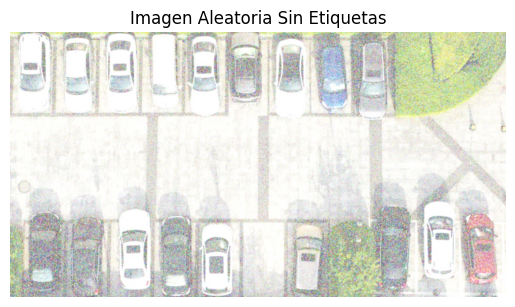

In [18]:
import cv2
import matplotlib.pyplot as plt
import os
import random

train_images_modified_dir = '/content/dataset_modified/mydata/mydata/images/train'

# Listar imágenes
train_image_modified_files = sorted(os.listdir(train_images_modified_dir))

# Seleccionar una imagen aleatoria
random_image_file = random.choice(train_image_modified_files)

# Cargar la imagen aleatoria
image_path = os.path.join(train_images_modified_dir, random_image_file)
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Mostrar la imagen
plt.imshow(image)
plt.axis('off')
plt.title("Imagen Aleatoria Sin Etiquetas")
plt.show()


2. Análisis de las Imágenes modificadas

Analizando imágenes del dataset modificado...


100%|██████████| 280/280 [00:06<00:00, 40.51it/s]


Análisis completado. Resumen guardado en image_analysis_modified_summary.csv

Resumen Estadístico:
             Width       Height  Brightness    Contrast       Noise  \
count   280.000000   280.000000  280.000000  280.000000  280.000000   
mean   1336.228571  1127.475000  220.407227   29.816679   88.566784   
std     171.704917   126.949484    6.700402    3.094213    7.386839   
min     881.000000   806.000000  195.684744   17.770790   67.960449   
25%    1211.000000  1038.000000  216.317530   28.323327   84.128802   
50%    1345.000000  1119.000000  219.931431   30.358397   89.258978   
75%    1468.000000  1221.000000  224.372729   31.855164   93.356613   
max    1733.000000  1444.000000  242.074462   38.800761  108.422112   

       Edge Density  
count    280.000000  
mean       0.057105  
std        0.018106  
min        0.012035  
25%        0.046461  
50%        0.057335  
75%        0.070057  
max        0.108580  


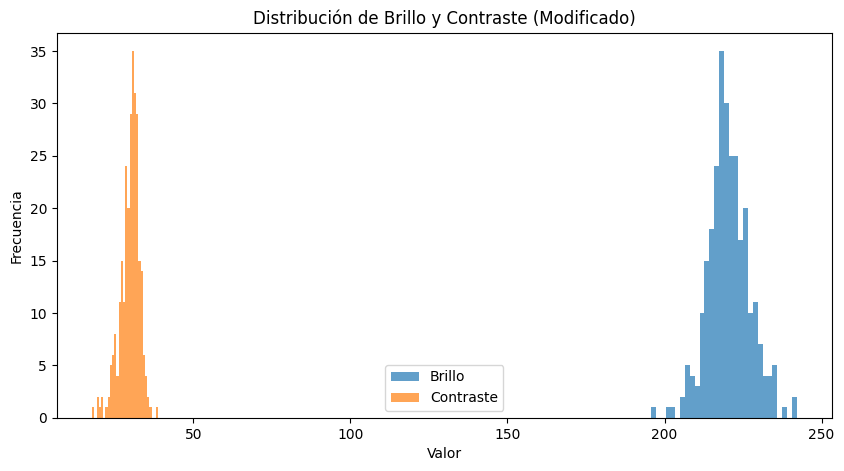

In [21]:
import cv2
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# Ruta al directorio del dataset modificado
images_dir = '/content/dataset_modified/mydata/mydata/images/train'

# Funciones para análisis
def analyze_image(image_path):
    """Analiza propiedades de una imagen y retorna un diccionario con los resultados."""
    # Cargar imagen
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Dimensiones de la imagen
    height, width = gray.shape

    # Brillo promedio
    brightness = np.mean(gray)

    # Contraste (desviación estándar de los valores de intensidad)
    contrast = np.std(gray)

    # Ruido estimado (diferencia promedio entre la imagen y un filtro de suavizado)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    noise = np.mean(np.abs(gray - blurred))

    # Bordes detectados (Canny)
    edges = cv2.Canny(gray, 100, 200)
    edge_density = np.sum(edges > 0) / (height * width)

    return {
        "Width": width,
        "Height": height,
        "Brightness": brightness,
        "Contrast": contrast,
        "Noise": noise,
        "Edge Density": edge_density
    }

# Analizar todas las imágenes
results = []
image_files = sorted(os.listdir(images_dir))

print("Analizando imágenes del dataset modificado...")
for image_file in tqdm(image_files):
    image_path = os.path.join(images_dir, image_file)
    analysis = analyze_image(image_path)
    analysis["Image"] = image_file
    results.append(analysis)

# Convertir los resultados en un DataFrame
df = pd.DataFrame(results)

# Guardar el análisis como un archivo CSV
output_file = "image_analysis_modified_summary.csv"
df.to_csv(output_file, index=False)

print(f"Análisis completado. Resumen guardado en {output_file}")

# Mostrar resumen estadístico
print("\nResumen Estadístico:")
print(df.describe())

# Visualizar histogramas de brillo y contraste
plt.figure(figsize=(10, 5))
plt.hist(df["Brightness"], bins=30, alpha=0.7, label="Brillo")
plt.hist(df["Contrast"], bins=30, alpha=0.7, label="Contraste")
plt.title("Distribución de Brillo y Contraste (Modificado)")
plt.xlabel("Valor")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()


4. Validación del modelo con las imágenes modificadas

In [22]:
# Directorios de imágenes y pesos del modelo
modified_images_dir = '/content/dataset_modified/mydata/mydata/images/test'
weights_path = 'runs/train/original_model/weights/best.pt'
output_dir = 'runs/detect/test_on_modified'

# Configuración de YOLOv5
!python detect.py \
--weights {weights_path} \
--source {modified_images_dir} \
--img 640 \
--conf 0.5 \
--save-txt \
--save-conf \
--project runs/detect \
--name test_on_modified

# Procesar resultados
detections_dir = os.path.join(output_dir, 'labels')
image_files = sorted(os.listdir(modified_images_dir))
detection_files = sorted(os.listdir(detections_dir))

print("Mostrando resultados...")
for image_file, detection_file in tqdm(zip(image_files, detection_files), total=len(image_files)):
    # Cargar la imagen
    image_path = os.path.join(modified_images_dir, image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Cargar detecciones
    detection_path = os.path.join(detections_dir, detection_file)
    with open(detection_path, 'r') as f:
        detections = f.readlines()

    # Contar carros detectados
    car_count = len(detections)
    print(f"Carros detectados en {image_file}: {car_count} carros")

    # Dibujar cajas delimitadoras en la imagen
    h, w, _ = image.shape
    for detection in detections:
        class_id, x_center, y_center, width, height, conf = map(float, detection.strip().split())
        x1 = int((x_center - width / 2) * w)
        y1 = int((y_center - height / 2) * h)
        x2 = int((x_center + width / 2) * w)
        y2 = int((y_center + height / 2) * h)
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # Mostrar la imagen con detecciones
    plt.figure(figsize=(10, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{image_file} - Carros detectados: {car_count}")
    plt.show()

detect: weights=['runs/train/original_model/weights/best.pt'], source=/content/dataset_modified/mydata/mydata/images/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=test_on_modified, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-388-g882c35fc Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Traceback (most recent call last):
  File "/content/yolov5/detect.py", line 437, in <module>
    main(opt)
  File "/content/yolov5/detect.py", line 432, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py", line 116, in decorate_context
    return func(*args, **kwargs)
  File "/content

  0%|          | 0/19 [00:00<?, ?it/s]


# Comparación entre modelos